In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

## Extract Data

In [5]:
fast_food = 'Resources/FastFoodRestaurants.csv'

In [6]:
fast_food_df = pd.read_csv(fast_food)
fast_food_df.head()

,address,city,country,keys,latitude,longitude,name,postalCode,province,websites
0,324 Main St,Massena,US,us/ny/massena/324mainst/-1161002137,44.92130,-74.89021,McDonald's,13662,NY,"http://mcdonalds.com,http://www.mcdonalds.com/..."
1,530 Clinton Ave,Washington Court House,US,us/oh/washingtoncourthouse/530clintonave/-7914...,39.53255,-83.44526,Wendy's,43160,OH,http://www.wendys.com
2,408 Market Square Dr,Maysville,US,us/ky/maysville/408marketsquaredr/1051460804,38.62736,-83.79141,Frisch's Big Boy,41056,KY,"http://www.frischs.com,https://www.frischs.com..."
3,6098 State Highway 37,Massena,US,us/ny/massena/6098statehighway37/-1161002137,44.95008,-74.84553,McDonald's,13662,NY,"http://mcdonalds.com,http://www.mcdonalds.com/..."
4,139 Columbus Rd,Athens,US,us/oh/athens/139columbusrd/990890980,39.35155,-82.09728,OMG! Rotisserie,45701,OH,"http://www.omgrotisserie.com,http://omgrotisse..."


In [7]:
population = 'Resources/State Populations.csv'

In [8]:
population_df = pd.read_csv(population)
population_df.head()

,State,2018 Population
0,California,39776830
1,Texas,28704330
2,Florida,21312211
3,New York,19862512
4,Pennsylvania,12823989


In [10]:
abbr_url= 'https://simple.wikipedia.org/wiki/U.S._postal_abbreviations#States'
state_abbr = pd.read_html(abbr_url)[1]
state_abbr.head()

,State Abbreviation,State Name
0,AK,Alaska
1,AL,Alabama
2,AR,Arkansas
3,AZ,Arizona
4,CA,California


# Transforming Data

In [13]:
fast_food_cols = ['name', 'city', 'province']
fast_food_transformed = fast_food_df[fast_food_cols].copy()
fast_food_transformed.head()

,name,city,province
0,McDonald's,Massena,NY
1,Wendy's,Washington Court House,OH
2,Frisch's Big Boy,Maysville,KY
3,McDonald's,Massena,NY
4,OMG! Rotisserie,Athens,OH


In [23]:
fast_food_transformed = fast_food_transformed.rename(columns={'city':'City','name':'Restaurant_Name', 'province': 'State'})
fast_food_transformed =fast_food_transformed[["State", "City", "Restaurant_Name"]]
fast_food_transformed.head()

,State,City,Restaurant_Name
0,NY,Massena,McDonald's
1,OH,Washington Court House,Wendy's
2,KY,Maysville,Frisch's Big Boy
3,NY,Massena,McDonald's
4,OH,Athens,OMG! Rotisserie


In [17]:
us_state_population=pd.merge(population_df, state_abbr, left_on='State', right_on='State Name')
us_state_population.head()

,State,2018 Population,State Abbreviation,State Name
0,California,39776830,CA,California
1,Texas,28704330,TX,Texas
2,Florida,21312211,FL,Florida
3,New York,19862512,NY,New York
4,Pennsylvania,12823989,PA,Pennsylvania


In [21]:
us_state_population=us_state_population.rename (columns={'2018 Population':"Population"})
us_state_population=us_state_population.drop(["State"], axis=1)
us_state_population=us_state_population[["State Abbreviation", "State Name", "Population"]]
us_state_population.head()

,State Abbreviation,State Name,Population
0,CA,California,39776830
1,TX,Texas,28704330
2,FL,Florida,21312211
3,NY,New York,19862512
4,PA,Pennsylvania,12823989


# Load Data into Database

In [27]:
db_connection_string = "postgres:XXXX@localhost:5432/ETL"
engine = create_engine(f'postgresql://{db_connection_string}')

In [28]:
engine.table_names()

['restaurant', 'state_population']

In [29]:
us_state_population.to_sql(name='state_population', con=engine, if_exists='append', index=False)

In [30]:
pd.read_sql_query('select * from state_population', con=engine).head()

,State Abbreviation,State Name,Population
0,CA,California,39776830
1,TX,Texas,28704330
2,FL,Florida,21312211
3,NY,New York,19862512
4,PA,Pennsylvania,12823989


In [31]:
fast_food_transformed.to_sql(name="restaurant", con=engine, if_exists='append', index=False)
pd.read_sql_query('select * from restaurant', con=engine).head()

,State,City,Restaurant_Name
0,NY,Massena,McDonald's
1,OH,Washington Court House,Wendy's
2,KY,Maysville,Frisch's Big Boy
3,NY,Massena,McDonald's
4,OH,Athens,OMG! Rotisserie


# Data Exploration

In [40]:
#Creating bar graph for total fast food restaurants per state
top_15_rest_count = pd.read_sql_query('SELECT r."State", s."Population", COUNT(r."Restaurant_Name") restaurant_count FROM state_population s\
                  JOIN restaurant r ON s."State Abbreviation" = r."State"\
                  GROUP BY r."State", s."Population" ORDER BY restaurant_count DESC LIMIT 15;', con=engine)
top_15_rest_count

,State,Population,restaurant_count
0,CA,39776830,676
1,TX,28704330,634
2,OH,11694664,543
3,FL,21312211,471
4,IN,6699629,379
5,IL,12768320,363
6,NC,10390149,358
7,GA,10545138,347
8,MO,6135888,334
9,KY,4472265,332


In [45]:
top_15_rest_count.dtypes

State               object
Population           int64
restaurant_count     int64
dtype: object

In [37]:
#Number of restaurants in the top 15 most populous states
rest_most_pop_state = pd.read_sql_query('SELECT r."State", s."Population", COUNT(r."Restaurant_Name") restaurant_count FROM state_population s\
                  JOIN restaurant r ON s."State Abbreviation" = r."State"\
                  GROUP BY r."State", s."Population" ORDER BY s."Population" DESC LIMIT 15;', con=engine)
rest_most_pop_state

,State,Population,restaurant_count
0,CA,39776830,676
1,TX,28704330,634
2,FL,21312211,471
3,NY,19862512,269
4,PA,12823989,283
5,IL,12768320,363
6,OH,11694664,543
7,GA,10545138,347
8,NC,10390149,358
9,MI,9991177,251


In [46]:
rest_most_pop_state.dtypes

State               object
Population           int64
restaurant_count     int64
dtype: object

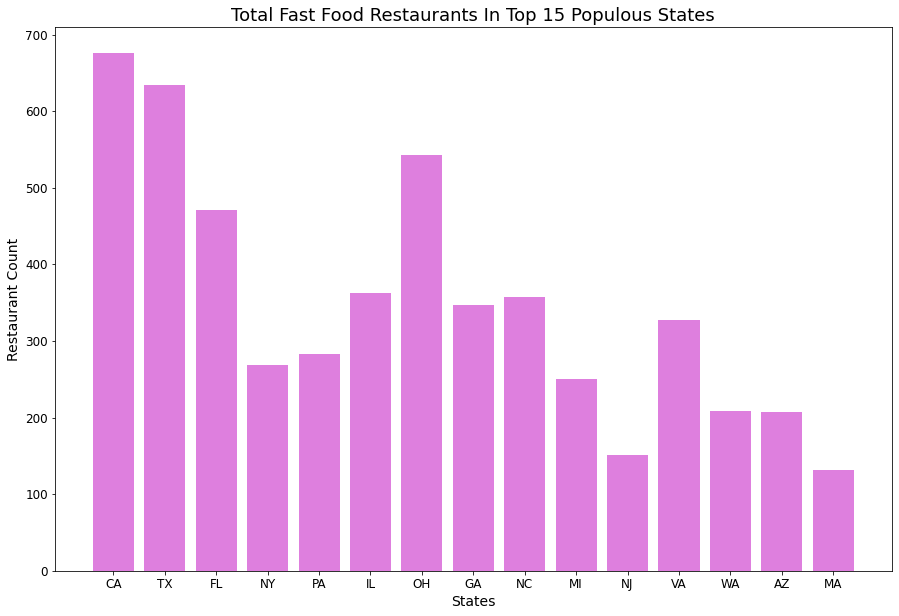

In [38]:
plt.figure(figsize=(15,10))
rest_most_pop_state_plt = plt.bar(rest_most_pop_state['State'], rest_most_pop_state['restaurant_count'], color = 'm', alpha = .5)
plt.xlabel('States', size = 14)
plt.xticks(size = 12)
plt.ylabel('Restaurant Count', size = 14)
plt.yticks(size = 12)
plt.show()

In [47]:
#California restaurants
california_rest = pd.read_sql_query('SELECT s."State Name", r."Restaurant_Name", COUNT(r."Restaurant_Name") Restaurant_Name_Count FROM state_population s\
                                JOIN restaurant r ON s."State Abbreviation" = r."State"\
                                WHERE s."State Name" = \'California\'\
                                GROUP BY r."Restaurant_Name", s."State Name"\
                                ORDER BY Restaurant_Name_Count DESC LIMIT 10;', con=engine)
california_rest

,State Name,Restaurant_Name,restaurant_name_count
0,California,McDonald's,121
1,California,Taco Bell,70
2,California,Jack in the Box,65
3,California,Burger King,58
4,California,Carl's Jr.,42
5,California,Subway,28
6,California,El Pollo Loco,27
7,California,Del Taco,27
8,California,Wendy's,26
9,California,KFC,24


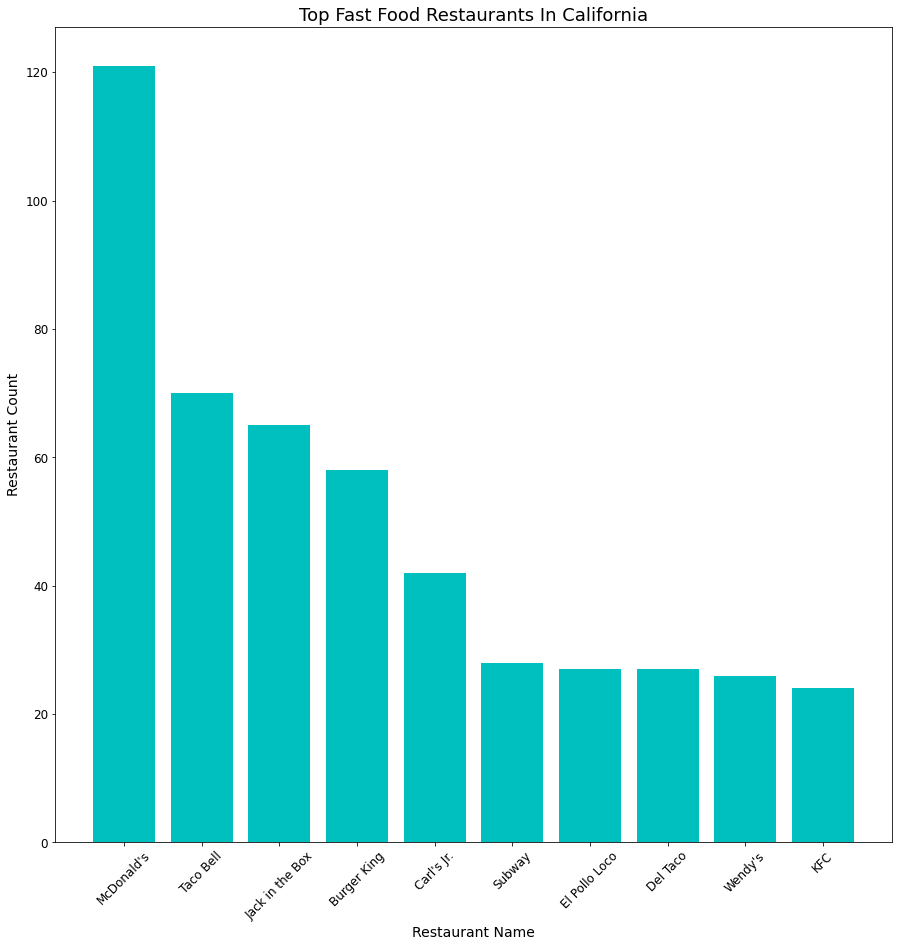

In [48]:
#Creating bar graph for number of restaurants in California
plt.figure(figsize=(15,15))
cali_plt = plt.bar(california_rest['Restaurant_Name'], california_rest['restaurant_name_count'], color = 'c')
plt.xlabel('Restaurant Name', size = 14)
plt.xticks(size = 12, rotation=45)
plt.ylabel('Restaurant Count', size = 14)
plt.yticks(size = 12)
plt.title('Top Fast Food Restaurants In California', size=18)
plt.show()